#Reading a netcdf file

1.  Fetch the netcdf file tropical.nc from my webserver (50 Mbytes)

In [10]:
import urllib.request
import numpy as np
from netCDF4 import Dataset
urllib.request.urlretrieve("http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc", 
                           "tropical_subset.nc")

('tropical_subset.nc', <http.client.HTTPMessage at 0x108e7ad30>)

2.  Identify the file structure using ncdump

In [25]:
!ncinfo tropical_subset.nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    dimensions(sizes): x(100), y(110), z(112), time(1)
    variables(dimensions): float32 x(x), float32 y(y), float32 z(z), float32 time(time), float32 p(z), float32 U(time,z,y,x), float32 V(time,z,y,x), float32 W(time,z,y,x), float32 PP(time,z,y,x), float32 TABS(time,z,y,x), float32 QV(time,z,y,x), float32 QN(time,z,y,x), float32 QP(time,z,y,x)
    groups: 



3.  Read a variable using the netCDF4 module:  http://unidata.github.io/netcdf4-python/

In [12]:
with Dataset('tropical_subset.nc','r') as nc_in:
    print(list(nc_in.variables.keys()))
    the_temp=nc_in.variables['TABS'][...]
    print(the_temp.shape)
    #
    # remove the time dimension since we only have one timestep
    #
    the_temp=the_temp.squeeze()
    print(the_temp.shape)
    the_height=nc_in.variables['z'][...]
    print(the_height.shape)
    the_press=nc_in.variables['p'][...]
    the_press=the_press*100.  #convert to Pa
    wvel=nc_in.variables['W'][...]
    



['x', 'y', 'z', 'time', 'p', 'U', 'V', 'W', 'PP', 'TABS', 'QV', 'QN', 'QP']
(1, 112, 110, 100)
(112, 110, 100)
(112,)


#Plotting three temperature profiles

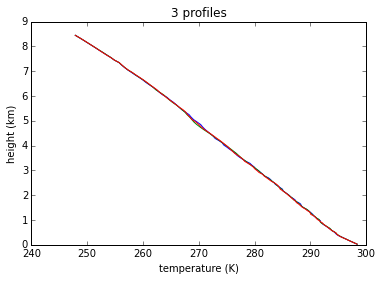

In [13]:
%matplotlib inline
#
# plot 3 arbitrary columns
#
from matplotlib import pyplot as plt
meter2km=1.e-3
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    temp_profile=the_temp[:,x,y]
    ax.plot(temp_profile,the_height*meter2km)  
ax.set(xlabel='temperature (K)',ylabel='height (km)',title='3 profiles')

# Calculate the horizontal average temperature

In [14]:
print(the_temp.shape)
xmean=the_temp.mean(axis=2)
print(xmean.shape)
xymean=xmean.mean(axis=1)
print(xymean.shape)

(112, 110, 100)
(112, 110)
(112,)


#Calculate the temperature pertubation

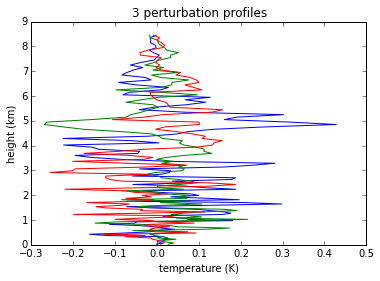

In [15]:
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    temp_profile=the_temp[:,x,y] - xymean
    ax.plot(temp_profile,the_height*meter2km)  
ax.set(xlabel='temperature (K)',ylabel='height (km)',title='3 perturbation profiles')

#Assignment for Wednesday, Sept. 16: 11am

1.  Write a function that takes TABS and p and returns $\theta$, the potential temperature

1.  Make a plot of the vertical profile of $\overline{w^\prime \theta^\prime}$ vs. z for
    this model timestep

1.  Upload your version of this notebook to the cloud (Dropbox, googledrive etc.) and
    email me a link

In [16]:
def theta(p,T):
    """
      input: p (Pa), scalar pressure
             T (K),  scalar or array of temperatures
      output: thetaval (K) potential temperature
    """
    Rd=287  #dry air gas constant  J/kg/K
    cp=1004.  #dry air heat capacity at constant pressure (J/kg/K)
    p0=1.e5  #reference pressure (Pa)
    the_exp=Rd/cp
    thetaval=T*(p0/p)**the_exp
    return thetaval


###Calculate theta at every level

In [26]:
thetavals=np.empty_like(the_temp)
for lev,press_lev in enumerate(the_press):
    thetavals[lev,:,:]=theta(press_lev,the_temp[lev,:,:])   

###Plot some profiles

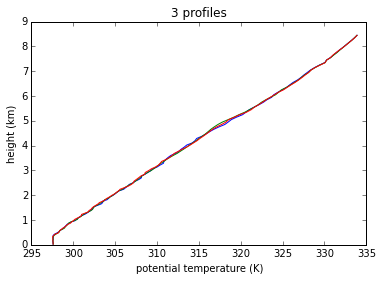

In [18]:
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    theta_profile=thetavals[:,x,y]
    ax.plot(theta_profile,the_height*meter2km)  
ax.set(xlabel='potential temperature (K)',ylabel='height (km)',title='3 profiles')

###Find the perturbation wrt

In [29]:
wvel.shape
neww=wvel.squeeze()
neww.shape

(112, 110, 100)

In [ ]:
w_bar=wvel.mean(axis=2).mean(axis=1)
w_prime= wvel - w_bar

In [19]:
print(w_prime.shape)
thetavals2=thetavals[np.newaxis,...] #make shape (1,112,110,100)
theta_bar=thetavals2.mean(axis=2).mean(axis=1)
theta_prime= thetavals2 - theta_bar
flux=w_prime*theta_prime
flux=flux.squeeze()  #make shape (112,110,100)
mean_flux=flux.mean(axis=2).mean(axis=1)

(1, 112, 110, 100)


In [20]:
theta_bar.shape

(1, 100)

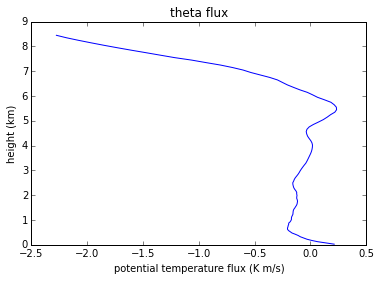

In [21]:
fig,ax=plt.subplots(1,1)
ax.plot(mean_flux,the_height*meter2km)
ax.set(xlabel='potential temperature flux (K m/s)',ylabel='height (km)',title='theta flux')

#Getting started with vapor

1. Install vapor per [these instructions](https://www.vapor.ucar.edu/docs/usage/getting-started-vapor)
1. Download and unzip the following file:

In [22]:
urllib.request.urlretrieve("http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical.zip", 
                           "tropical.zip")

('tropical.zip', <http.client.HTTPMessage at 0x115f895c0>)

Start vapor, go to "Data -> Load dataset into current session" and see if you get a
3-d visualization of TABS

###Getting a ten member ensemble for the dry boundary layer les

In [23]:
root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
for i in np.arange(1,11,dtype=np.int):
    the_name='mar12014_{:d}_15600.nc'.format(i)
    print(the_name)
    url='{}/{}'.format(root,the_name)
    urllib.request.urlretrieve(url,the_name)
    
    

mar12014_1_15600.nc
mar12014_2_15600.nc
mar12014_3_15600.nc
mar12014_4_15600.nc
mar12014_5_15600.nc
mar12014_6_15600.nc
mar12014_7_15600.nc
mar12014_8_15600.nc
mar12014_9_15600.nc
mar12014_10_15600.nc


###Assignment for Monday, Sept. 21

1. Hand in a notebook that

   1. plots the ensemble average theta profile for 1 column, and the ensemble averaged vertical heat flux
      in Watts/m^2 through the bottom model layer.
      
   1. histogram the normalized pressure perturbation $p^\prime/p(z)$ for 1 ensemble member
   
2. Read the rest of Stull chapter 2 and do problem 8 if you haven't already